In [1]:
file_path = 'claims_sample_data.xlsx'

In [ ]:
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
claims_data = pd.read_excel(file_path)

claims_data.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [4]:
claims_data.describe()

,MONTH,PAID_AMOUNT
count,52152.000000,5.215200e+04
mean,201885.029567,3.708707e+03
std,72.867005,3.449842e+04
min,201801.000000,-4.223000e+04
25%,201808.000000,1.940000e+02
50%,201903.000000,5.860000e+02
75%,201911.000000,1.465000e+03
max,202007.000000,2.268611e+06


In [5]:
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [6]:
claims_data['MONTH'] = pd.to_datetime(claims_data['MONTH'], format='%Y%m', errors='coerce')

In [7]:
claims_data.dropna(subset=['MONTH'], inplace=True)
claims_data['CLAIM_SPECIALTY'].fillna('Unknown', inplace=True)

<ipython-input-8-416ca1b8ad3b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = claims_data.groupby(pd.Grouper(key='MONTH', freq='M')).sum()


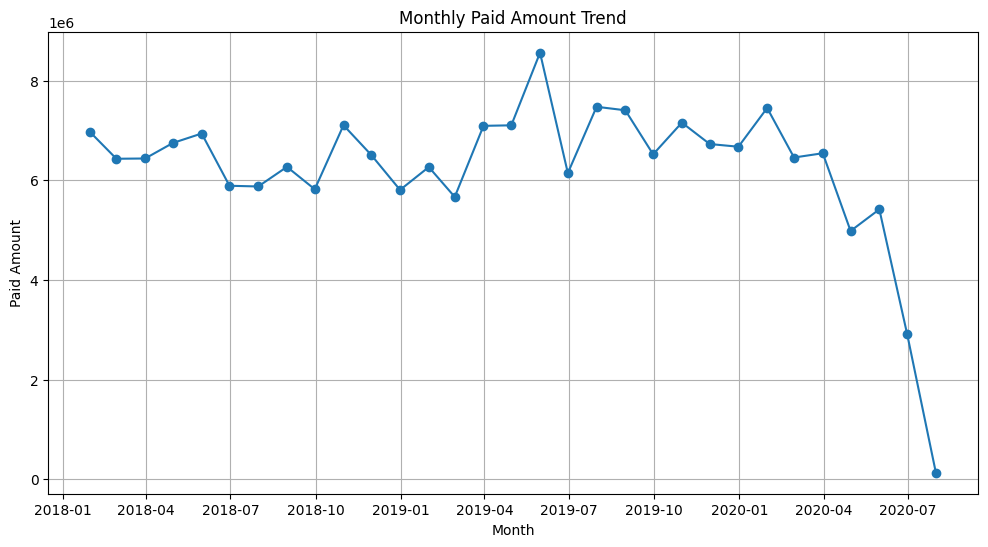

In [8]:
monthly_data = claims_data.groupby(pd.Grouper(key='MONTH', freq='M')).sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['PAID_AMOUNT'], marker='o')
plt.title('Monthly Paid Amount Trend')
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.grid(True)
plt.show()

1. **Overall Trend:** There is a general upward trend in the paid amount over time until around the end of 2019. After that, there seems to be a plateau and then a significant drop around mid-2020.

2. **Seasonality:** There appears to be some seasonal patterns, with spikes that could suggest increased claim payments in certain months. To confirm seasonality, we would typically look for consistent peaks or troughs at the same time each year.

3. **Anomaly:** The sharp decline at the end of the graph, around July 2020, stands out as an anomaly. This could be due to incomplete data for the month, a significant change in claims processing, or an external factor affecting the number of claims.

4. **Contextual Factors:** The steep decline in mid-2020 might coincide with external factors such as the COVID-19 pandemic, which could have affected the volume of claims or the operations of insurance companies and healthcare providers.

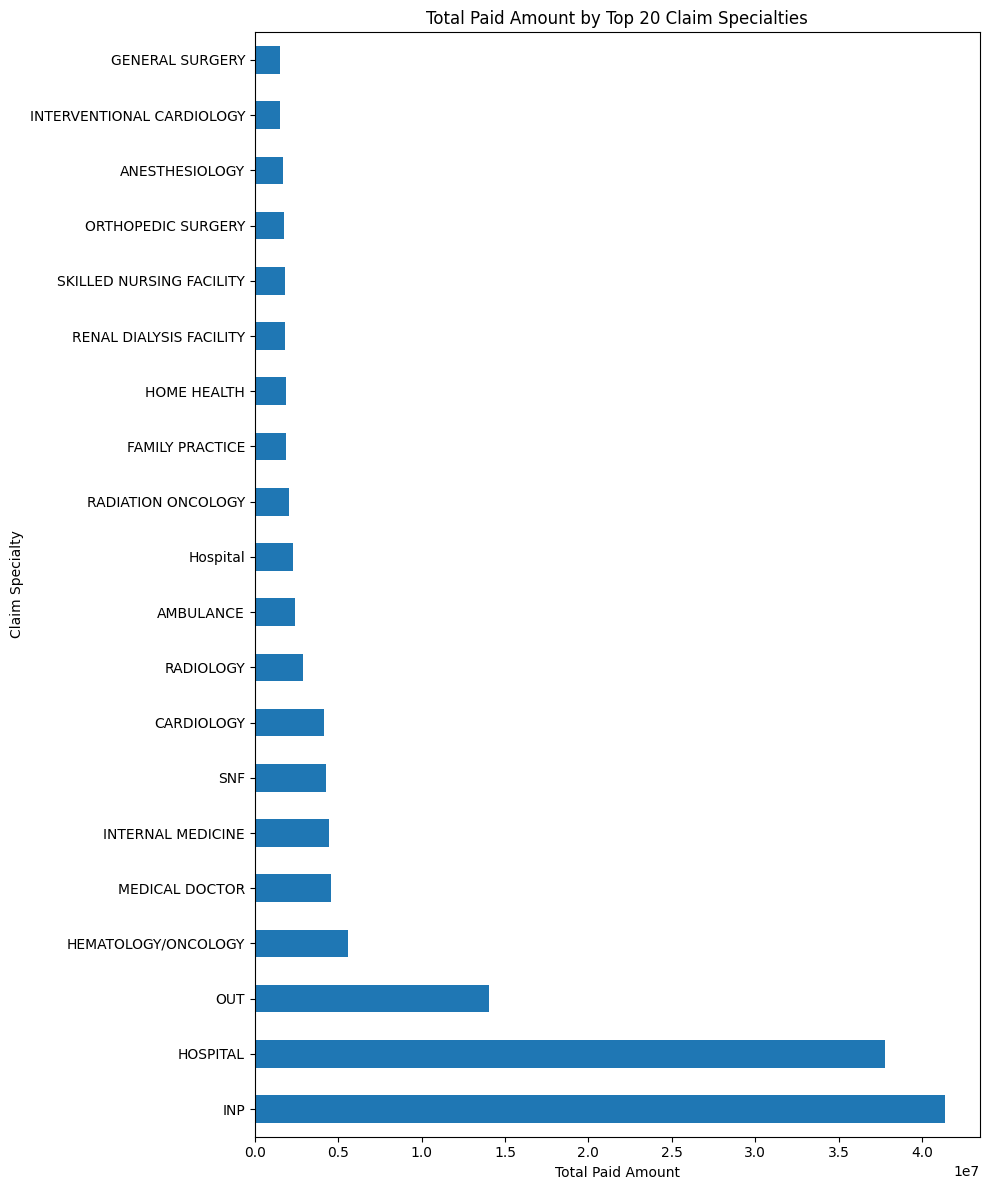

In [9]:
specialty_analysis = claims_data.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT'].agg(['sum', 'mean', 'median', 'count'])
specialty_analysis = specialty_analysis.sort_values(by='sum', ascending=False)

top_specialties = specialty_analysis.head(20)

top_specialties['sum'].plot(kind='barh', figsize=(10, 12))
plt.title('Total Paid Amount by Top 20 Claim Specialties')
plt.xlabel('Total Paid Amount')
plt.ylabel('Claim Specialty')
plt.tight_layout()
plt.show()

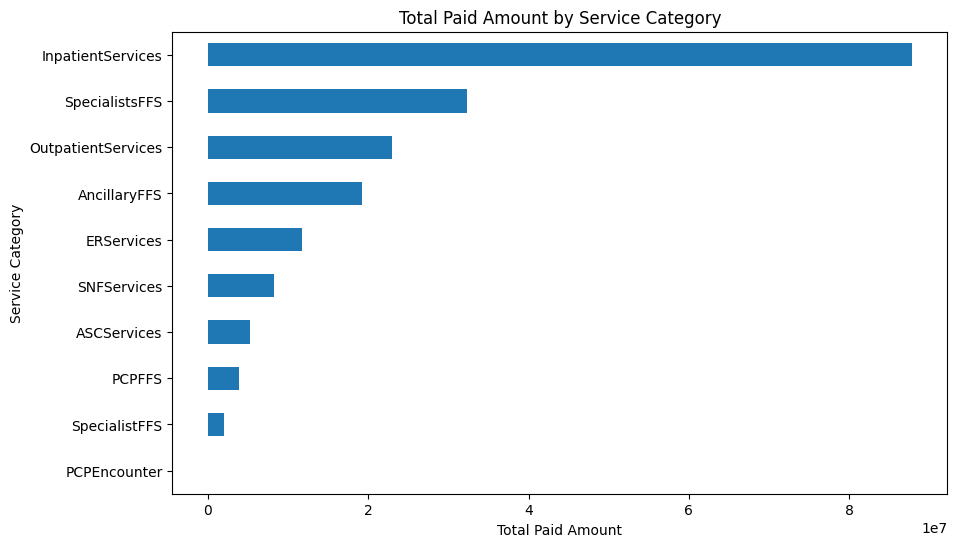

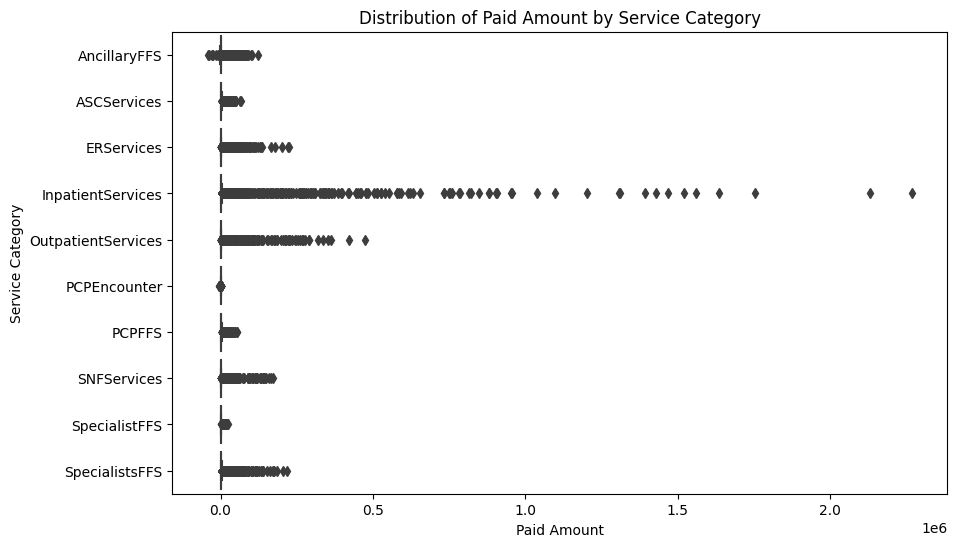

In [10]:
category_summary = claims_data.groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].agg(['sum', 'mean', 'median', 'count'])

plt.figure(figsize=(10, 6))
category_summary['sum'].sort_values().plot(kind='barh')
plt.title('Total Paid Amount by Service Category')
plt.xlabel('Total Paid Amount')
plt.ylabel('Service Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='PAID_AMOUNT', y='SERVICE_CATEGORY', data=claims_data)
plt.title('Distribution of Paid Amount by Service Category')
plt.xlabel('Paid Amount')
plt.ylabel('Service Category')
plt.show()

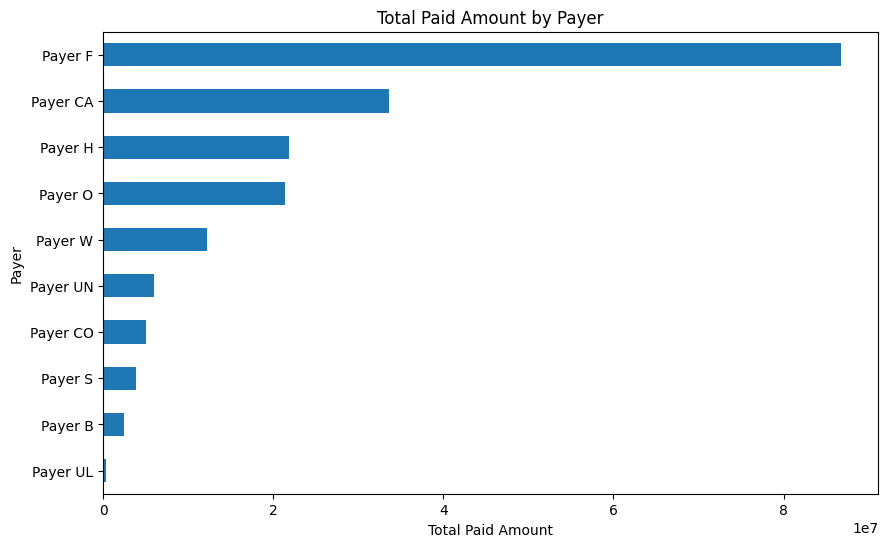

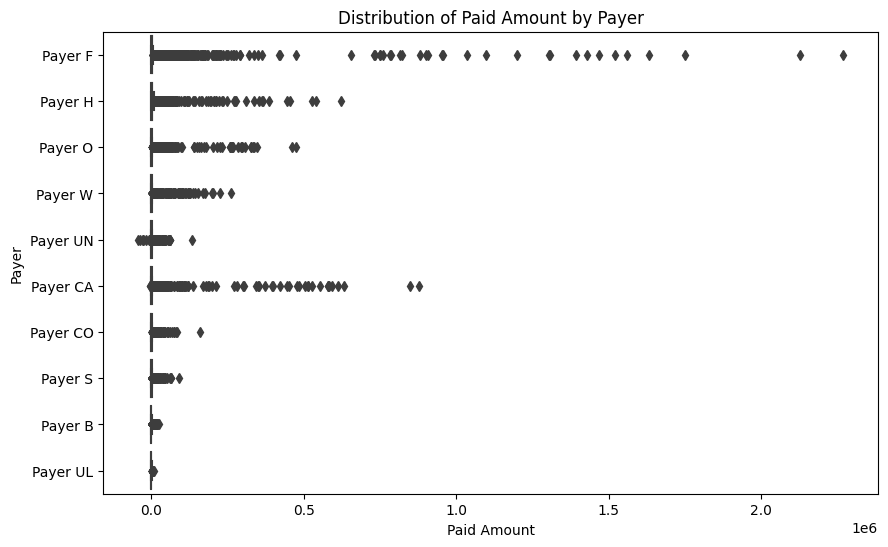

In [11]:
payer_summary = claims_data.groupby('PAYER')['PAID_AMOUNT'].agg(['sum', 'mean', 'median', 'count'])

plt.figure(figsize=(10, 6))
payer_summary['sum'].sort_values().plot(kind='barh')
plt.title('Total Paid Amount by Payer')
plt.xlabel('Total Paid Amount')
plt.ylabel('Payer')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='PAID_AMOUNT', y='PAYER', data=claims_data)
plt.title('Distribution of Paid Amount by Payer')
plt.xlabel('Paid Amount')
plt.ylabel('Payer')
plt.show()

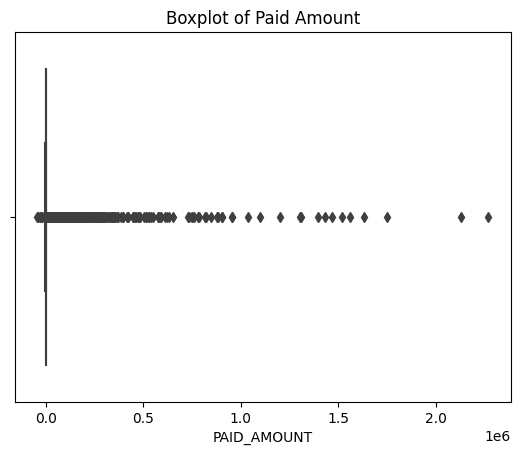

In [12]:
sns.boxplot(x=claims_data['PAID_AMOUNT'])
plt.title('Boxplot of Paid Amount')
plt.show()

particularly high payments, some reaching over 2 million, are well outside the typical range for the dataset

In [13]:
claims_data.rename(columns={'MONTH': 'ds', 'PAID_AMOUNT': 'y'}, inplace=True)

upper_threshold = claims_data['y'].quantile(0.95)
claims_data['y'] = claims_data['y'].clip(upper=upper_threshold)

claims_data.dropna(subset=['ds', 'y'], inplace=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb1zk_f6/n_2larhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb1zk_f6/duxhp0tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91781', 'data', 'file=/tmp/tmpnb1zk_f6/n_2larhf.json', 'init=/tmp/tmpnb1zk_f6/duxhp0tl.json', 'output', 'file=/tmp/tmpnb1zk_f6/prophet_model1dxeh0r5/prophet_model-20231112201015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


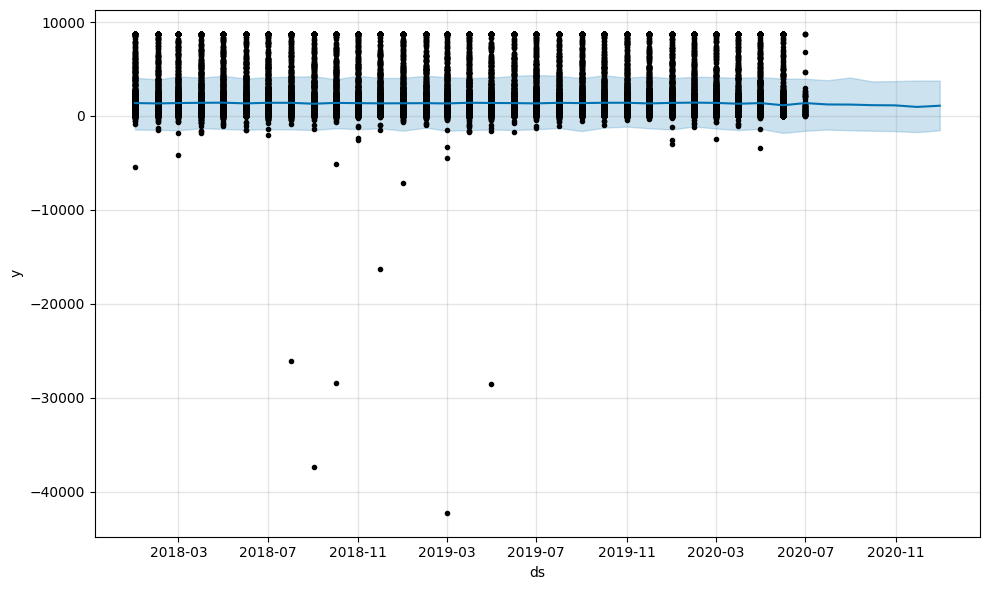

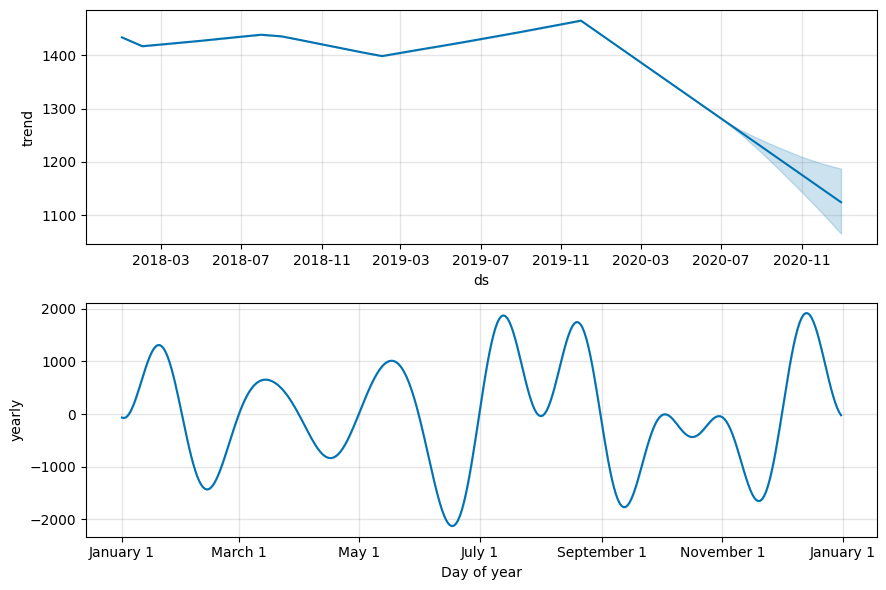

In [17]:
df_prophet = claims_data.rename(columns={'MONTH': 'ds', 'PAID_AMOUNT': 'y'})

m = Prophet()

m.fit(df_prophet)

future = m.make_future_dataframe(periods=6, freq='M')

forecast = m.predict(future)

fig = m.plot(forecast)

components_fig = m.plot_components(forecast)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast.csv', index=False)